In [ ]:
import sys
from pathlib import Path

exp_dir = str(Path("..").resolve())
if exp_dir not in sys.path:
    sys.path.insert(0, exp_dir)

In [ ]:
from pathlib import Path

import numpy as np
import torch

# 사용자 모듈 임포트
from config import CONFIG
from xrr_model import XRR1DRegressor


class XRRInferenceEngine:
    def __init__(self, exp_dir=None):
        """
        추론 엔진 초기화: 설정 로드, 모델 로드, 통계 로드
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[Inference] Device: {self.device}")

        # 1. 경로 설정
        if exp_dir is None:
            exp_dir = Path(CONFIG["base_dir"]) / CONFIG["exp_name"]
        else:
            exp_dir = Path(exp_dir)

        self.stats_file = exp_dir / "stats.pt"
        self.checkpoint_file = exp_dir / "best.pt"

        # 2. Master Grid 설정 (학습과 동일해야 함)
        self.q_min = CONFIG["simulation"].get("q_min", 0.0)
        self.q_max = CONFIG["simulation"].get("q_max", 0.5)
        self.n_points = CONFIG["simulation"].get("q_points", 200)

        # 모델이 바라보는 고정된 q축 생성
        self.target_q = np.linspace(self.q_min, self.q_max, self.n_points).astype(np.float32)

        # 3. 정규화 통계 로드
        if not self.stats_file.exists():
            raise FileNotFoundError(f"통계 파일이 없습니다: {self.stats_file}")

        stats = torch.load(self.stats_file, map_location=self.device)
        self.param_mean = stats["param_mean"]
        self.param_std = stats["param_std"]

        # 4. 모델 로드
        self._load_model()

    def _load_model(self):
        """모델 생성 및 가중치 로드"""
        if not self.checkpoint_file.exists():
            raise FileNotFoundError(f"체크포인트가 없습니다: {self.checkpoint_file}")

        # 체크포인트에서 모델 설정 가져오기 (없으면 Config 사용)
        ckpt = torch.load(self.checkpoint_file, map_location=self.device)
        model_args = ckpt.get('config', {}).get('model_args', {
            'q_len': self.n_points,
            'input_channels': 2, # [중요] 2채널 고정
            'n_channels': CONFIG["model"]["n_channels"],
            'depth': CONFIG["model"]["depth"],
            'mlp_hidden': CONFIG["model"]["mlp_hidden"],
        })

        self.model = XRR1DRegressor(**model_args).to(self.device)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()
        print(f"[Inference] Model loaded from {self.checkpoint_file}")

    def preprocess(self, q_raw, R_raw):
        """
        Raw Data -> Model Input Tensor 변환
        (Dataset.__getitem__ 로직과 동일하게 구현)
        """
        # 1. Normalize R (Max Norm -> Log10)
        R_max = np.max(R_raw)
        R_norm = R_raw / (R_max + 1e-15)
        R_log = np.log10(np.maximum(R_norm, 1e-15))

        # 2. Interpolation (Master Grid로 내삽)
        # q_raw가 오름차순이어야 np.interp가 정확함
        if q_raw[0] > q_raw[-1]:
            q_raw = q_raw[::-1]
            R_log = R_log[::-1]

        R_interp = np.interp(self.target_q, q_raw, R_log, left=0.0, right=0.0)

        # 3. Masking
        q_valid_mask = (self.target_q >= np.min(q_raw)) & (self.target_q <= np.max(q_raw))

        # 4. Tensor 변환 & Stacking
        R_tensor = torch.from_numpy(R_interp.astype(np.float32))
        mask_tensor = torch.from_numpy(q_valid_mask.astype(np.float32))

        # Shape: (2, n_points)
        input_tensor = torch.stack([R_tensor, mask_tensor], dim=0)

        # Batch 차원 추가: (1, 2, n_points)
        return input_tensor.unsqueeze(0).to(self.device)

    def predict(self, q_raw, R_raw):
        """
        단일 데이터 추론 수행
        Returns: (thickness, roughness, sld) -> 실제 물리 단위
        """
        # 전처리
        x = self.preprocess(q_raw, R_raw)

        # 추론
        with torch.no_grad():
            # Output: (1, 3) -> Normalized Params
            y_pred_norm = self.model(x).squeeze(0)

        # 역정규화 (Denormalization)
        # Z-score 역변환: X = Z * Std + Mean
        y_pred = y_pred_norm * self.param_std + self.param_mean

        # Tensor -> Numpy / List 변환
        return y_pred.cpu().numpy()

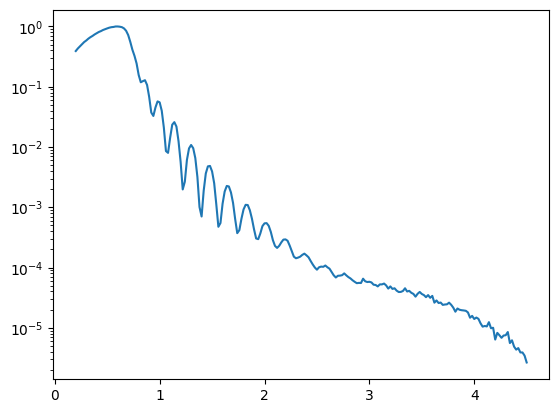

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from reflecto.simulate.simul_genx import ParamSet

file = r"D:\03_Resources\Data\XRR_AI\XRR_data\XRR_data\#3_xrr.dat"
df = pd.read_csv(file, header=None, sep=r"\s+", names=["tth", "R"])

tth_measured = df["tth"].to_numpy()
refl = df["R"].to_numpy()
refl = refl / refl.max()
# refl = refl / refl[0]
plt.plot(tth_measured, refl)
plt.yscale("log")

In [ ]:
from reflecto.simulate.simul_genx import params2refl, tth2q_wavelen

engine = XRRInferenceEngine(exp_dir=r"D:\03_Resources\Data\XRR_AI\data\one_layer\mask2")

# 2. 가상의 측정 데이터 (예시: qs와 true_refl이 있다고 가정)
# 실제 상황에서는 qs, true_refl = load_my_data()
print("\n--- Single Data Prediction ---")

# 테스트용 더미 데이터 생성 (사용자 데이터로 교체하세요)
test_q = tth2q_wavelen(tth_measured)
test_R = refl

# 3. 예측 실행
thickness_pred, roughness_pred, sld_pred = engine.predict(test_q, test_R)
param = ParamSet(thickness_pred, roughness_pred, sld_pred)

print("Predicted Parameters:")
print(f"  Thickness: {thickness_pred:.4f} Å")
print(f"  Roughness: {roughness_pred:.4f} Å")
print(f"  SLD:       {sld_pred:.4e} (10^-6 Å^-2)")

[Inference] Device: cuda
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\mask2\best.pt

--- Single Data Prediction ---
Predicted Parameters:
  Thickness: 180.6528 Å
  Roughness: 10.5284 Å
  SLD:       2.2972e+00 (10^-6 Å^-2)


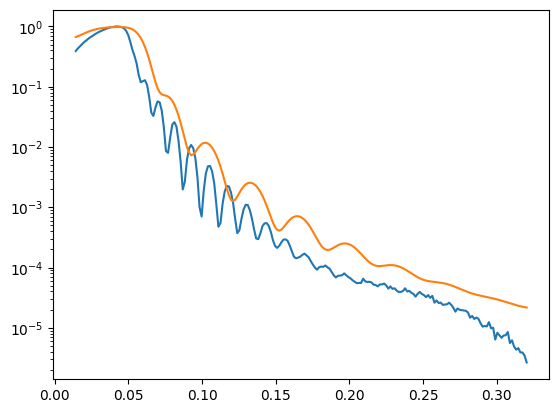

In [ ]:
param = ParamSet(thickness_pred, roughness_pred, sld_pred)
sim_refl = params2refl([param], test_q)

plt.plot(test_q, refl)
plt.plot(test_q, sim_refl)
plt.yscale("log")

plt.show()

In [ ]:
from genx import fom_funcs
from genx.data import DataList, DataSet
from genx.model import Model
from genx.parameters import Parameters

# 1) 측정 데이터 준비
qz = test_q
R  = refl
dR = np.maximum(refl*0.3, 1e-8)

ds = DataSet(name="XRR 1-layer")
ds.x_raw = qz
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

# 2) 스크립트 작성
# [수정 1] param.sld가 어떤 단위인지 모르겠지만,
# script 내부에는 "10^-6 A^-2" 단위의 숫자(예: 2.0, 18.5)로 넘기는 것이 좋습니다.
# 여기서는 param.sld가 1e-6 단위라고 가정하고 그대로 넣습니다.
script_text = rf"""
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType
# [핵심] 물리 상수 r_e (2.8179e-5) 가져오기
from genx.models.lib.physical_constants import r_e 

# 초기값 (단위: 10^-6 A^-2 로 통일)
initial_thickness = {param.thickness}
initial_roughness = {param.roughness}
initial_sld       = {param.sld}       # 예: 2.07

SI_SLD_VAL = 2.07 # 기판 SLD (10^-6 A^-2 단위)
initial_I0 = 1.0

class Vars:
    def __init__(self, d, sigma, sld, i0):
        self._d = float(d)
        self._sigma = float(sigma)
        self._sld = float(sld)
        self._i0 = float(i0)
    def set_thickness(self, v): self._d = float(v)
    def get_thickness(self):    return self._d
    def set_roughness(self, v): self._sigma = float(v)
    def get_roughness(self):    return self._sigma
    def set_sld(self, v):       self._sld = float(v)
    def get_sld(self):          return self._sld
    def set_I0(self, v):        self._i0 = float(v)
    def get_I0(self):           return self._i0

vars = Vars(initial_thickness, initial_roughness, initial_sld, initial_I0)

# [핵심] SLD -> f 변환 함수
# GenX X-ray: SLD = dens * f * r_e
# 따라서 f = SLD_real / (dens * r_e)
def get_f_from_sld(sld_1e6):
    # 입력: 10^-6 단위 (예: 2.07) -> 실제값 2.07e-6
    real_sld = sld_1e6 * 1e-6
    # dens를 1.0으로 고정하고 f를 계산
    return real_sld / r_e

Amb = Layer(d=0.0, dens=0.0, f=0.0)

# 기판: 변환 함수 적용
Sub = Layer(d=0.0, f=get_f_from_sld(SI_SLD_VAL), dens=1.0, sigma=3.0)

# 박막: 초기값으로 설정 (Sim 호출 시 업데이트됨)
Film = Layer(d=vars.get_thickness(),
             sigma=vars.get_roughness(),
             f=get_f_from_sld(vars.get_sld()),
             dens=1.0)

# 표면층 (옵션)
SURFACE_SIO2 = Layer(
    d=15.0,
    f=complex(14, 0.1), # 이건 원자 단위(Si=14)로 쓴 것 같네요. dens=0.05와 결합됨.
    dens=0.05,
    sigma=2.0
)

sample = Sample(Stacks=[Stack(Layers=[SURFACE_SIO2, Film])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray,
    wavelength=1.54,
    coords=Coords.q,
    I0=vars.get_I0(),
    Ibkg=1e-10,
    res=0.005,
    restype=ResType.fast_conv,
    footype=FootType.gauss
)

def _sync():
    Film.d     = vars.get_thickness()
    Film.sigma = vars.get_roughness()
    # [핵심] 여기서도 변환 함수 사용 (일관성 유지)
    Film.f     = get_f_from_sld(vars.get_sld())
    inst.I0    = vars.get_I0()

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""

# 3) 모델 생성 및 컴파일
model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# 4) 파라미터 등록
pars = Parameters()

p_thick = pars.append("vars.set_thickness", model)
p_thick.value = param.thickness
p_thick.fit = True

p_rough = pars.append("vars.set_roughness", model)
p_rough.value = param.roughness
p_rough.fit = True

# [수정 2] SLD 파라미터 설정
p_sld = pars.append("vars.set_sld", model)
# 여기서 param.sld가 만약 2.07e-6 (실제값)이라면 -> 2.07로 변환해서 넣기
# 만약 param.sld가 이미 2.07이라면 그대로 넣기.
# (사용자 데이터에 따라 맞춰주세요. 여기서는 1e6을 곱해서 보기 편한 숫자로 만듦)
p_sld.value = param.sld if param.sld > 1 else param.sld * 1e6
p_sld.fit = True

p_i0 = pars.append("vars.set_I0", model)
p_i0.value = 1.0
p_i0.min = 0.1
p_i0.max = 10.0
p_i0.fit = False

model.parameters = pars

# ---------------------------------------------------------
# [단계 1] I0 피팅
# ---------------------------------------------------------
print("--- Step 1: Fitting I0 ---")
model.set_fom_func(fom_funcs.diff)
res_i0 = model.bumps_fit(method="dream", steps=200) # 가볍게 DE 사용
model.bumps_update_parameters(res_i0)
print(f"Fitted I0: {p_i0.value}")

# ---------------------------------------------------------
# [단계 2] 전체 피팅
# ---------------------------------------------------------
print("--- Step 2: Full Fitting ---")
model.set_fom_func(fom_funcs.log)

p_thick.fit = True
p_rough.fit = True
p_sld.fit   = True
p_i0.fit    = False # I0 고정

# Newton은 국소 최적화라 초기값이 나쁘면 발산할 수 있습니다. 'de' 추천.
res_final = model.bumps_fit(method="dream", steps=1000, pop=20, tol=0.01)
model.bumps_update_parameters(res_final)

model.evaluate_sim_func()
print("Final Results:")
for par in model.parameters:
    print(f"  {par.name} = {par.value}")

--- Step 1: Fitting I0 ---
Fitted I0: 1.0
--- Step 2: Full Fitting ---
Final Results:
   = 0.0
  vars.set_thickness = 443.79273836962966
  vars.set_roughness = 2.6400648923983816
  vars.set_sld = 6.547094200728118
  vars.set_I0 = 1.0


In [ ]:
import numpy as np
from genx import fom_funcs
from genx.data import DataList, DataSet
from genx.model import Model
from genx.parameters import Parameters

# ---------------------------------------------------------
# 1) 데이터 준비
# ---------------------------------------------------------
qz = params2refl(tth_measured)
R  = refl
dR = np.maximum(R * 0.1, 1e-9)

ds = DataSet(name="XRR 2-Layer Fit")
ds.x_raw = qz
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

# 초기값 설정
val_film_thick = param.thickness
val_film_rough = param.roughness
val_film_sld   = param.sld * 1e6 if param.sld < 1.0 else param.sld

# SiO2 (자연 산화막) 초기값
val_sio_d   = 15.0
val_sio_sig = 3.0
val_sio_sld = 18.8 # 초기값

# ---------------------------------------------------------
# 2) GenX 스크립트
# ---------------------------------------------------------
script_text = rf"""
import numpy as np
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType
from genx.models.lib.physical_constants import r_e

# 초기값 상수 주입
init_f_d   = {val_film_thick}
init_f_sig = {val_film_rough}
init_f_sld = {val_film_sld}

init_s_d   = {val_sio_d}
init_s_sig = {val_sio_sig}
init_s_sld = {val_sio_sld}

class Vars:
    def __init__(self):
        self.f_d   = float(init_f_d)
        self.f_sig = float(init_f_sig)
        self.f_sld = float(init_f_sld)
        
        self.s_d   = float(init_s_d)
        self.s_sig = float(init_s_sig)
        self.s_sld = float(init_s_sld) 
        
        self.i0    = 1.0

    # --- Film Get/Set ---
    def set_film_d(self, v):   self.f_d = float(v)
    def get_film_d(self):      return self.f_d
    
    def set_film_sig(self, v): self.f_sig = float(v)
    def get_film_sig(self):    return self.f_sig
    
    def set_film_sld(self, v): self.f_sld = float(v)
    def get_film_sld(self):    return self.f_sld

    # --- SiO2 Get/Set ---
    def set_sio_d(self, v):    self.s_d = float(v)
    def get_sio_d(self):       return self.s_d
    
    def set_sio_sig(self, v):  self.s_sig = float(v)
    def get_sio_sig(self):     return self.s_sig

    # [추가됨] SiO2 SLD 피팅용 함수
    def set_sio_sld(self, v):  self.s_sld = float(v)
    def get_sio_sld(self):     return self.s_sld

    # --- Inst Get/Set ---
    def set_i0(self, v):       self.i0 = float(v)
    def get_i0(self):          return self.i0

vars = Vars()

def get_f(sld_1e6):
    return complex(sld_1e6 * 1e-6 / r_e, 0)

# --- Layer 구성 ---
Amb = Layer(d=0.0, f=0.0, dens=0.0)
Sub = Layer(d=0.0, f=get_f(20.07), dens=1.0, sigma=3.0) # Si 기판

# Material 1: Main Film
Film = Layer(d=vars.get_film_d(), 
             sigma=vars.get_film_sig(), 
             f=get_f(vars.get_film_sld()), 
             dens=1.0)

# Material 2: Surface SiO2
SiO2 = Layer(d=vars.get_sio_d(),
             sigma=vars.get_sio_sig(),
             f=get_f(vars.get_sio_sld()), # 변수 연결
             dens=1.0)

sample = Sample(Stacks=[Stack(Layers=[Film, SiO2])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray, wavelength=1.54, coords=Coords.q,
    I0=vars.get_i0(), Ibkg=1e-10, res=0.002, 
    restype=ResType.fast_conv, footype=FootType.gauss
)

def _sync():
    # Film Update
    Film.d     = vars.get_film_d()
    Film.sigma = vars.get_film_sig()
    Film.f     = get_f(vars.get_film_sld())
    
    # SiO2 Update
    SiO2.d     = vars.get_sio_d()
    SiO2.sigma = vars.get_sio_sig()
    SiO2.f     = get_f(vars.get_sio_sld()) # [핵심] SLD 업데이트 추가
    
    inst.I0    = vars.get_i0()

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""

model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# ---------------------------------------------------------
# 3) 파라미터 등록
# ---------------------------------------------------------
pars = Parameters()

# [Material 1: Main Film]
p_f_d = pars.append("vars.set_film_d", model)
p_f_d.value = val_film_thick; p_f_d.min=10; p_f_d.max=1000

p_f_sig = pars.append("vars.set_film_sig", model)
p_f_sig.value = val_film_rough; p_f_sig.min=0; p_f_sig.max=30

p_f_sld = pars.append("vars.set_film_sld", model)
p_f_sld.value = val_film_sld; p_f_sld.min=10; p_f_sld.max=50

# [Material 2: Surface SiO2]
p_s_d = pars.append("vars.set_sio_d", model)
p_s_d.value = val_sio_d; p_s_d.min=5; p_s_d.max=50

p_s_sig = pars.append("vars.set_sio_sig", model)
p_s_sig.value = val_sio_sig; p_s_sig.min=0; p_s_sig.max=20

# [추가됨] SiO2 SLD 파라미터
p_s_sld = pars.append("vars.set_sio_sld", model)
p_s_sld.value = val_sio_sld; p_s_sld.min=10.0; p_s_sld.max=25.0 # SiO2는 보통 18~20 사이

# [Instrument: I0]
p_i0 = pars.append("vars.set_i0", model)
p_i0.value = 1.0; p_i0.min=0.1; p_i0.max=100.0

model.parameters = pars

# =========================================================
# [1차 피팅] 오로지 I0만 피팅 (나머지 FALSE)
# =========================================================
print("\n=== Step 1: Fitting ONLY I0 ===")

# 1. I0만 켜기
p_i0.fit = True

# 2. 나머지는 모두 끄기
p_f_d.fit = False; p_f_sig.fit = False; p_f_sld.fit = False
p_s_d.fit = False; p_s_sig.fit = False; p_s_sld.fit = False

# 3. Linear Scale & Nelder-Mead (단일 변수에 안전함)
model.set_fom_func(fom_funcs.diff)
res_1 = model.bumps_fit(method="de")
model.bumps_update_parameters(res_1)

print(f" -> Step 1 Result I0: {p_i0.value:.4f}")


# =========================================================
# [2차 피팅] 물질 2개 모든 파라미터 + I0 피팅
# =========================================================
print("\n=== Step 2: Fitting ALL Parameters (Film + SiO2 + I0) ===")

# 1. 모든 파라미터 켜기
p_i0.fit = True
p_f_d.fit = True; p_f_sig.fit = True; p_f_sld.fit = True
p_s_d.fit = True; p_s_sig.fit = True; p_s_sld.fit = True

# 2. Log Scale 사용
model.set_fom_func(fom_funcs.log)

# 3. Differential Evolution (DE) 실행
res_2 = model.bumps_fit(method="de", steps=600, pop=20, tol=0.005)
model.bumps_update_parameters(res_2)

# 4. 결과 확인
model.evaluate_sim_func()

print("\n--- Final Fitted Parameters ---")
print(f"I0             : {p_i0.value:.3f}")
print(f"Film Thickness : {p_f_d.value:.2f} Å")
print(f"Film Roughness : {p_f_sig.value:.2f} Å")
print(f"Film SLD       : {p_f_sld.value:.3f}")
print("-" * 30)
print(f"SiO2 Thickness : {p_s_d.value:.2f} Å")
print(f"SiO2 Roughness : {p_s_sig.value:.2f} Å")
print(f"SiO2 SLD       : {p_s_sld.value:.3f}") # 수정됨: SiO2 변수 출력


=== Step 1: Fitting ONLY I0 ===
 -> Step 1 Result I0: 83.7836

=== Step 2: Fitting ALL Parameters (Film + SiO2 + I0) ===


d:\02_Projects\Dev\X-ray_AI\Reflecto\.venv\Lib\site-packages\bumps\fitproblem.py:631: UserWarning: Unsatisfied constraints: [vars__film_sld=4.0 is outside (10.0,50.0)]
  warnings.warn("Unsatisfied constraints: [%s]" % (",\n".join(broken)))



--- Final Fitted Parameters ---
I0             : 100.000
Film Thickness : 308.15 Å
Film Roughness : 0.00 Å
Film SLD       : 50.000
------------------------------
SiO2 Thickness : 28.18 Å
SiO2 Roughness : 0.00 Å
SiO2 SLD       : 10.000


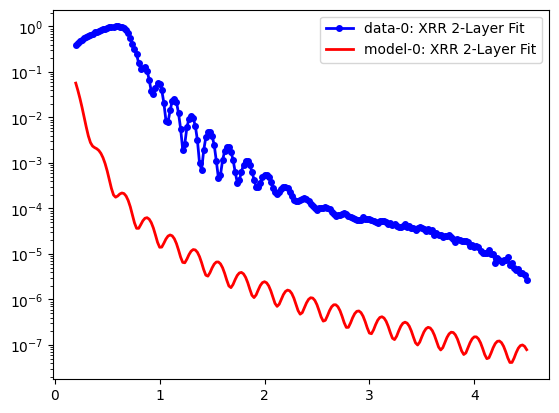

In [ ]:
from genx.diffev import DiffEv
from genx.model_control import ModelController

controller = ModelController(DiffEv())
controller.set_model(model)
controller.StartFit()

fitted = controller.get_fitted_model()
fitted.simulate()
fitted.data.plot()
plt.show()

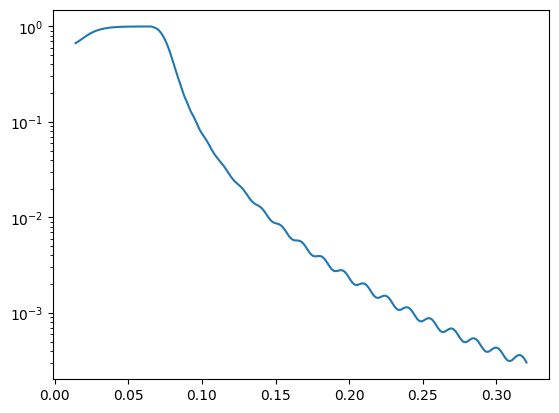

In [ ]:
param = ParamSet(400, 0, 4)
sim_refl = params2refl([param], test_q)

# plt.plot(test_q, refl)
plt.plot(test_q, sim_refl)
plt.yscale("log")

plt.show()